In [1]:
!pip install -q tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 41kB/s 
     |████████████████████████████████| 3.8MB 31.6MB/s 
     |████████████████████████████████| 450kB 38.6MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
ERROR: tb-nightly 2.1.0a20191029 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.


In [2]:
# 구글 드라이브 colab과 연동
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf
print(tf.__version__)

In [0]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import re
import time

from nltk.corpus import stopwords
import nltk.data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 데이터 로딩
- train data에 24999개의 리뷰 데이터를 갖고 있다.
- sentiment 분포도 균등하게 positive와 negative로 되어있고, binary encoded되어있다.  
- x,y로 데이터를 나누어준다. 


In [0]:
# 레이블인 sentiment가 있는 학습 데이터 
# Read data from files
train = pd.read_csv('/content/gdrive/My Drive/study/kaggle/word2vec-nlp-tutorial/labeledTrainData.tsv', 
                    delimiter='\t', quoting=3)

# 레이블이 없는 테스트 데이터 
test = pd.read_csv('/content/gdrive/My Drive/study/kaggle/word2vec-nlp-tutorial/testData.tsv',
                   delimiter='\t', quoting=3)
unlabeled_train = pd.read_csv('/content/gdrive/My Drive/study/kaggle/word2vec-nlp-tutorial/unlabeledTrainData.tsv',
                             delimiter='\t', quoting=3)

In [5]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [0]:
train.tail()

,id,sentiment,review
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."
24999,"""8478_8""",1,"""I saw this movie as a child and it broke my h..."


In [0]:
test.tail()

,id,review
24995,"""2155_10""","""Sony Pictures Classics, I'm looking at you! S..."
24996,"""59_10""","""I always felt that Ms. Merkerson had never go..."
24997,"""2531_1""","""I was so disappointed in this movie. I am ver..."
24998,"""7772_8""","""From the opening sequence, filled with black ..."
24999,"""11465_10""","""This is a great horror film for people who do..."


In [0]:
unlabeled_train.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [6]:
from google.colab import files
files.upload() 

Saving KaggleWord2VecUtility.py to KaggleWord2VecUtility.py


{'KaggleWord2VecUtility.py': b'import re\r\nimport nltk\r\n\r\nimport pandas as pd\r\nimport numpy as np\r\n\r\nfrom bs4 import BeautifulSoup\r\nfrom nltk.corpus import stopwords\r\nfrom nltk.stem.snowball import SnowballStemmer\r\n\r\nfrom multiprocessing import Pool\r\n\r\nclass KaggleWord2VecUtility(object):\r\n\r\n    @staticmethod\r\n    def review_to_wordlist(review, remove_stopwords=False):\r\n        # 1. HTML \xec\xa0\x9c\xea\xb1\xb0\r\n        review_text = BeautifulSoup(review, "html.parser").get_text()\r\n        # 2. \xed\x8a\xb9\xec\x88\x98\xeb\xac\xb8\xec\x9e\x90\xeb\xa5\xbc \xea\xb3\xb5\xeb\xb0\xb1\xec\x9c\xbc\xeb\xa1\x9c \xeb\xb0\x94\xea\xbf\x94\xec\xa4\x8c\r\n        review_text = re.sub(\'[^a-zA-Z]\', \' \', review_text)\r\n        # 3. \xec\x86\x8c\xeb\xac\xb8\xec\x9e\x90\xeb\xa1\x9c \xeb\xb3\x80\xed\x99\x98 \xed\x9b\x84 \xeb\x82\x98\xeb\x88\x88\xeb\x8b\xa4.\r\n        words = review_text.lower().split()\r\n        # 4. \xeb\xb6\x88\xec\x9a\xa9\xec\x96\xb4 \xec\xa0\

In [0]:
from KaggleWord2VecUtility import KaggleWord2VecUtility
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

def review_to_words(raw_review):
  review_text = BeautifulSoup(raw_review, "html.parser").get_text()
  review_text = wordnet_lemmatizer.lemmatize(review_text)
  return review_text


In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [9]:
# 학습 데이터를 전처리 
%time train['review_clean']=KaggleWord2VecUtility.apply_by_multiprocessing(\
                            train['review'], KaggleWord2VecUtility.review_to_join_words, workers=4) 

CPU times: user 169 ms, sys: 165 ms, total: 334 ms
Wall time: 1min 15s


In [10]:
# 테스트 데이터 전처리 
%time test['review_clean'] = KaggleWord2VecUtility.apply_by_multiprocessing(\
                            test['review'], KaggleWord2VecUtility.review_to_join_words, workers=4)

CPU times: user 170 ms, sys: 168 ms, total: 338 ms
Wall time: 1min 13s


In [11]:
train['review_clean'][:10]

0    with all this stuff go down at the moment with...
1    the classic war of the world by timothi hine i...
2    the film start with a manag nichola bell give ...
3    it must be assum that those who prais this fil...
4    superbl trashi and wondrous unpretenti s explo...
5    i dont know whi peopl think this is such a bad...
6    this movi could have been veri good but come u...
7    i watch this video at a friend s hous i m glad...
8    a friend of mine bought this film for and even...
9    this movi is full of refer like mad max ii the...
Name: review_clean, dtype: object

In [0]:
# X_train과 X_test에 리뷰테이터를 담아주고 이 데이터를 임베딩(벡터화)해본다. 
X_train = train['review_clean']
X_test = test['review_clean']

In [0]:
clean_train_df = pd.DataFrame({'review':X_train, 'sentiment':train['sentiment']})

In [14]:
clean_train_df.head()

,review,sentiment
0,with all this stuff go down at the moment with...,1
1,the classic war of the world by timothi hine i...,1
2,the film start with a manag nichola bell give ...,0
3,it must be assum that those who prais this fil...,0
4,superbl trashi and wondrous unpretenti s explo...,1


In [0]:
clean_test_df = pd.DataFrame({'review':X_test, 'id':test['id']})

In [16]:
clean_test_df.head()

,review,id
0,natur in a film who s main theme are of mortal...,"""12311_10"""
1,this movi is a disast within a disast film it ...,"""8348_2"""
2,all in all this is a movi for kid we saw it to...,"""5828_4"""
3,afraid of the dark left me with the impress th...,"""7186_2"""
4,a veri accur depict of small time mob life fil...,"""12128_7"""


In [0]:
# 문자열 문장 리스트를 토크나이징
tokenized_reviews = [r.split() for r in X_train]

# 토크나이징된 리스트에 대한 각 길이를 저장 
review_len_by_token = [len(t) for t in tokenized_reviews]

# 토크나이징된 것을 붙여서 음절의 길이를 저장 
review_len_by_eumjeol = [len(s.replace(' ','')) for s in X_train]

In [18]:
print('문장 최대길이 : {}'.format(np.max(review_len_by_token)))
print('문장 최소길이 : {}'.format(np.min(review_len_by_token)))
print('문장 평균길이 : {:.2f}'.format(np.mean(review_len_by_token)))
print('문장 중간길이 : {}'.format(np.median(review_len_by_token)))

# 사분위에 대한 경우 0~100 스케일
print('1사분위 길이 : {}'.format(np.percentile(review_len_by_token,25)))
print('3사분위 길이 : {}'.format(np.percentile(review_len_by_token,75)))

문장 최대길이 : 2487
문장 최소길이 : 10
문장 평균길이 : 236.83
문장 중간길이 : 177.0
1사분위 길이 : 129.0
3사분위 길이 : 287.0


{'boxes': [<matplotlib.lines.Line2D at 0x7f6ebe912c18>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6ebe925518>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6ebe937240>],
 'means': [<matplotlib.lines.Line2D at 0x7f6ebe925ef0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6ebe925ba8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6ebe912e48>,
  <matplotlib.lines.Line2D at 0x7f6ebe9251d0>]}

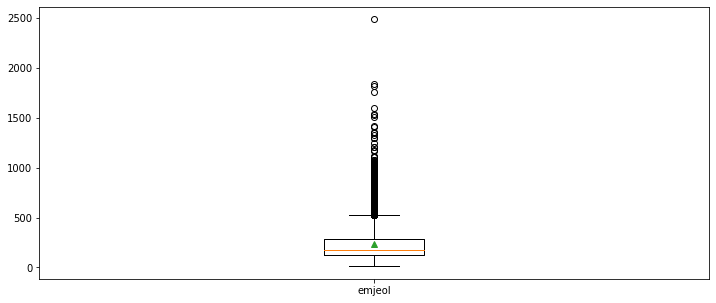

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,5))
# 박스플롯생성
plt.boxplot([review_len_by_token],
            labels = ['emjeol'],
            showmeans = True)


In [20]:
from keras.preprocessing.text import Tokenizer
# 토크나이저 모듈을 생성한 후 정제된 데이터에 적용하고 인덱스로 구서오딘 벡터로 변환한다. 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
text_sequences = tokenizer.texts_to_sequences(X_train)

Using TensorFlow backend.


In [0]:
test_id = np.array(test['id'])

# 토크나이저 모듈을 생성한 후 정제된 데이터에 적용하고 인덱스로 구서오딘 벡터로 변환한다. 
tokenizer.fit_on_texts(X_test)
text_sequences = tokenizer.texts_to_sequences(X_test)

In [0]:
print(text_sequences[0])

[18, 30, 10, 586, 89, 195, 31, 1, 274, 18, 6936, 9, 148, 181, 1006, 5, 28, 179, 60, 1, 772, 626, 136, 2, 39, 60, 1, 12845, 2, 60, 7879, 188, 315, 9, 42, 123, 5, 57, 3, 342, 1624, 93, 10, 171, 36, 9, 197, 14, 69, 678, 8, 1, 3105, 42, 5, 315, 51, 61, 65, 313, 776, 26, 6, 2296, 41, 1015, 7879, 6, 144, 3660, 144, 402, 15, 67, 9, 371, 89, 5, 58, 31, 1, 476, 55, 7, 14, 186, 393, 49, 4, 7, 46, 1298, 699, 43, 6936, 12, 147, 729, 1, 2214, 2, 91, 1, 339, 699, 4, 846, 27, 80, 152, 3262, 634, 503, 19, 4, 299, 10, 6, 30, 43, 525, 1552, 37, 950, 21, 1507, 33, 6936, 8, 567, 105, 21, 27, 89, 5, 545, 10, 2, 142, 7, 294, 49, 222, 273, 6936, 35, 7740, 17, 8402, 5, 1, 51, 4, 10, 13, 19, 6936, 2, 84, 4, 28, 225, 66, 113, 11, 26, 103, 7, 17, 1, 225, 67, 45, 317, 6, 69, 322, 4, 98, 1, 155, 402, 15, 227, 55, 7, 242, 181, 6, 68, 22, 17, 199, 41, 37, 7310, 1, 2606, 1122, 461, 2, 935, 7741, 6, 609, 16, 3, 3688, 30, 386, 846, 1450, 145, 26, 123, 6936, 369, 37, 80, 6, 770, 76, 95, 6936, 15714, 28, 783, 10035, 935,

이제 전체 데이터가 인덱스로 구성돼 있을텐데 각 인덱스가 어떤 단어를 의미하는지 확인할 수 있어야 한다. 그래서 단어사전이 필요하다. 

In [22]:
word_vocab = tokenizer.word_index
print(word_vocab)

{'the': 1, 'and': 2, 'a': 3, 'of': 4, 'to': 5, 'is': 6, 'it': 7, 'in': 8, 'i': 9, 'this': 10, 'that': 11, 's': 12, 'movi': 13, 'film': 14, 'was': 15, 'as': 16, 'for': 17, 'with': 18, 'but': 19, 'you': 20, 't': 21, 'on': 22, 'be': 23, 'not': 24, 'have': 25, 'he': 26, 'are': 27, 'his': 28, 'one': 29, 'all': 30, 'at': 31, 'they': 32, 'like': 33, 'by': 34, 'an': 35, 'who': 36, 'so': 37, 'from': 38, 'there': 39, 'or': 40, 'just': 41, 'her': 42, 'out': 43, 'about': 44, 'if': 45, 'has': 46, 'what': 47, 'time': 48, 'some': 49, 'good': 50, 'make': 51, 'can': 52, 'charact': 53, 'see': 54, 'more': 55, 'when': 56, 'get': 57, 'watch': 58, 'veri': 59, 'she': 60, 'up': 61, 'even': 62, 'no': 63, 'stori': 64, 'my': 65, 'would': 66, 'which': 67, 'onli': 68, 'realli': 69, 'their': 70, 'had': 71, 'well': 72, 'me': 73, 'other': 74, 'scene': 75, 'do': 76, 'we': 77, 'were': 78, 'look': 79, 'show': 80, 'bad': 81, 'than': 82, 'much': 83, 'most': 84, 'end': 85, 'will': 86, 'great': 87, 'peopl': 88, 'been': 89, 

In [23]:
print("전체 단어 개수 : ",len(word_vocab))

전체 단어 개수 :  70242


In [0]:
data_configs = {}

data_configs['vocab'] =  word_vocab
data_configs['vocab_size'] = len(word_vocab)+1

마지막 처리과정 

각 데이터의 길이를 통일 : 

특정 길이를 최대 길이로 정하고 

더 긴 데이터의 경우 뒷부분을 자르고 짧은 데이터의 경우에는 0값으로 패딩하는 작업을 진행. 

In [25]:
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 172
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')
print('shape of train data:', train_inputs.shape)

shape of train data: (25000, 172)


In [0]:
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [0]:
#학습시 라벨 , 즉 정답값을 넘파이 배열로 저장한다. 이유는 전처리한 데이터를 저장할때 넘파이 형태로저장하기 때문이다. 
train_labels = np.array(train['sentiment'])
print('shape of label tensor', train_labels.shape)

shape of label tensor (25000,)


## 전처리 데이터를 이후 모델링 과정에서 사용하기 위해 저장하기 

- 정제된 텍스트 데이터 
- 벡터화한 데이터
- 정답 라벨
- 데이터 정보(단어 사전, 전체 단어 개수)

In [0]:
DATA_IN_PATH = '/content/gdrive/My Drive/study/kaggle/word2vec-nlp-tutorial'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA= 'train_label.npy'
TRAIN_CLEAN_DATA= 'train_clean.csv'
DATA_CONFIGS = 'data_configs.json'

import os
if not os.path.exists(DATA_IN_PATH):
  os.makedirs(DATA_IN_PATH)

In [0]:
# 전처리된 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

# 정제된 데이터를 csv형태로 저장
clean_train_df.to_csv(DATA_IN_PATH +TRAIN_CLEAN_DATA, index=False)

import json
# 데이터 사전을 json형태로 저장
json.dump(data_configs, open(DATA_IN_PATH+DATA_CONFIGS, 'w'), ensure_ascii = False)


In [0]:
# 테스트 셋도 동일하게 적용
TEST_INPUT_DATA= 'test_input.npy'
TEST_CLEAN_DATA= 'test_clean.csv'
TEST_IN_DATA = 'test_id.npy'

In [0]:
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_IN_DATA, 'wb'), test_id)
clean_test_df.to_csv(DATA_IN_PATH+TEST_CLEAN_DATA, index=False)

### 현재 저장하는 과정에서 sentiment가 들어있지 않다. 

## TF-IDF를 활용한 모델 구현
- 입력값이 텍스트로 이뤄진 데이터 형태여야 한다. 

- mid_df : 설정한 값보다 특정 토큰의 df값이 더 적게 나오면 벡터화 과정에서 제거한다. 
- analyzer : 분석하기 위한 기준 단위
- 'word', 'char'두가지 옵션 : 단어하나 단위, 문자 하나 단위
- sublinear_tf : 문서의 단어 빈도 수 에 대한 스무딩 여부를 설정하는 값


In [0]:
train_data = pd.read_csv("/content/gdrive/My Drive/study/kaggle/word2vec-nlp-tutorialtrain_clean.csv",header=0, quoting=3)

In [29]:
train_data.head()

,review,sentiment
0,with all this stuff go down at the moment with...,1
1,the classic war of the world by timothi hine i...,1
2,the film start with a manag nichola bell give ...,0
3,it must be assum that those who prais this fil...,0
4,superbl trashi and wondrous unpretenti s explo...,1


In [0]:
reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

In [31]:
reviews[:10]

['with all this stuff go down at the moment with mj i ve start listen to his music watch the odd documentari here and there watch the wiz and watch moonwalk again mayb i just want to get a certain insight into this guy who i thought was realli cool in the eighti just to mayb make up my mind whether he is guilti or innoc moonwalk is part biographi part featur film which i rememb go to see at the cinema when it was origin releas some of it has subtl messag about mj s feel toward the press and also the obvious messag of drug are bad m kay visual impress but of cours this is all about michael jackson so unless you remot like mj in anyway then you are go to hate this and find it bore some may call mj an egotist for consent to the make of this movi but mj and most of his fan would say that he made it for the fan which if true is realli nice of him the actual featur film bit when it final start is onli on for minut or so exclud the smooth crimin sequenc and joe pesci is convinc as a psychopat

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.0,
                             analyzer="char",
                             sublinear_tf = True,
                             ngram_range=(1,3),
                             max_features = 5000)
X = vectorizer.fit_transform(reviews)

In [0]:
# 학습과 검증 데이터셋 분리 
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
TEST_SPLIT = 0.2

y = np.array(sentiments)

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = TEST_SPLIT, random_state = RANDOM_SEED)

### regression 인자 값 중 class_weight = 'balanced'
: 각 라벨에 대해 균형 있게 학습 할 수 있게 한다. 
---



In [34]:
# 모델 선언 및 학습 
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight = 'balanced')
lgs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
print("Accuracy: %f"% lgs.score(X_eval, y_eval))

Accuracy: 0.861600


In [0]:
testDataVecs = vectorizer.transform(clean_test_df['review'])

In [37]:
test_predicted = lgs.predict(testDataVecs)
print(test_predicted)

[1 0 0 ... 0 1 0]


In [0]:
import os
import pandas as pd

answer_dataset = pd.DataFrame({'id':clean_test_df['id'], 'sentiment':test_predicted})
answer_dataset.to_csv('/content/gdrive/My Drive/study/kaggle/lgs_tfidf_answer.csv',index=False, quoting=3)

In [0]:
answer = pd.read_csv('/content/gdrive/My Drive/study/kaggle/lgs_tfidf_answer.csv')

In [39]:
answer.head()

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


### kaggle score는 0.85680

## word2vec을 활용한 모델 구현

- word2vec은 단어로 표현된 리스트를 입력값으로 넣어야 하기 때문에 전처리한 넘파이 배열을 사용하지 않는다. 

전처리한 텍스트 파일 --> 각 단어들을 리스트로 나누기

In [5]:
train_data = pd.read_csv("/content/gdrive/My Drive/study/kaggle/word2vec-nlp-tutorialtrain_clean.csv")
train_data.head()

,review,sentiment
0,with all this stuff go down at the moment with...,1
1,the classic war of the world by timothi hine i...,1
2,the film start with a manag nichola bell give ...,0
3,it must be assum that those who prais this fil...,0
4,superbl trashi and wondrous unpretenti s explo...,1


In [0]:
reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

sentences = []
for review in reviews:
  sentences.append(review.split(' '))

전처리한 경우 각 리뷰가 하나의 문자열로 이루어져 있다. 하지만 앞서 말했듯이 word2vec을 사용하기 위해서는 입력 값을 단어로 구분된 리스트로 만들어야 한다. 따라서 위와 같이 전체 리뷰를 단어 리스트로 바꿔야 한다. 

- 각 리뷰를 split함수를 이용해서 띄어쓰기로 구분한 뒤 리스트에 하나씩 추가해서 입력값을 만든다. 

### word2vec모델의 하이퍼 파라미터설정

In [0]:
# 학습시 필요한 하이퍼 파라미터 
num_features = 300    # 워드벡터 특징 값의 수/ 단어에 대해 임베딩된 벡터의 차원을 정한다. 
min_word_count = 40   # 모델에 의미있는 단어를 가지고 학습하기 위해 적은 빈도수의 단어들은 학습하지않는다. 
num_workers = 4       # 학습시 프로세스의 개수
context = 10          # 윈도우 크기 
downsampling = 1e-3   # 빠른 학습을 위해 정단 단어 라벨에 대한 다운샘플링 비율을 지정.보통 0.001이 좋은성능을 낸다고 한다. 

In [0]:
# 로그 수준이 info와 맞다면 로그메세지를 양식에 맞게 보여주자 
import logging
logging.basicConfig(format="%(asctime)s:%(levelname)s: %(message)s ", level= logging.INFO)

In [9]:
# 학습을 위한 객체 인자는 입력할 데이터와 하이퍼파라미터를 순서대로 입력해야 원하는 하이퍼 파라미터를 사용해 학습가능. 
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences,
                          workers = num_workers,
                          size = num_features,
                          min_count = min_word_count,
                          window = context,
                          sample = downsampling)

2019-10-30 05:50:58,767:INFO: 'pattern' package not found; tag filters are not available for English 
2019-10-30 05:50:58,776:INFO: collecting all words and their counts 
2019-10-30 05:50:58,777:INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types 


Training model...


2019-10-30 05:50:59,263:INFO: PROGRESS: at sentence #10000, processed 2385574 words, keeping 34468 word types 
2019-10-30 05:50:59,735:INFO: PROGRESS: at sentence #20000, processed 4747503 words, keeping 45517 word types 
2019-10-30 05:50:59,977:INFO: collected 50001 word types from a corpus of 5920713 raw words and 25000 sentences 
2019-10-30 05:50:59,979:INFO: Loading a fresh vocabulary 
2019-10-30 05:51:00,019:INFO: effective_min_count=40 retains 6517 unique words (13% of original 50001, drops 43484) 
2019-10-30 05:51:00,020:INFO: effective_min_count=40 leaves 5685787 word corpus (96% of original 5920713, drops 234926) 
2019-10-30 05:51:00,055:INFO: deleting the raw counts dictionary of 50001 items 
2019-10-30 05:51:00,059:INFO: sample=0.001 downsamples 51 most-common words 
2019-10-30 05:51:00,060:INFO: downsampling leaves estimated 4153318 word corpus (73.0% of prior 5685787) 
2019-10-30 05:51:00,087:INFO: estimated required memory for 6517 words and 300 dimensions: 18899300 bytes

word2vec으로 학습시킨 모델은 따로 저장해두면 이후 재사용이 가능!

In [45]:
# 모델의 하이퍼파라미터를 설정한 내용을 모델 이름에 담는다면 나중에 참고하기에 좋다. 
# 모델 저장 후 word2vec.load()통해 재사용 가능. 
model_name = "300features_40minwords_10context"
model.save(model_name)

2019-10-30 04:58:52,255:INFO: saving Word2Vec object under 300features_40minwords_10context, separately None 
2019-10-30 04:58:52,260:INFO: not storing attribute vectors_norm 
2019-10-30 04:58:52,268:INFO: not storing attribute cum_table 
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-10-30 04:58:52,423:INFO: saved 300features_40minwords_10context 


In [0]:
# 입력값을 하나의 형태로 만든는 방법
# 문장에 있는 모든 단어의 벡터값에 대해 평균을 낸다. -->리뷰하나당 하나의 벡터로 만든다. 
# words : 단어의 모음인 하나의 리뷰가 들어간다. 
# model : word2vec모델을 넣는 곳이며, 우리가 학습한 word2vec모델이 들어간다. 
# num_features : 임베딩시 정했던 벡터의 차원 수 
def get_features (words, model, num_features):
  # 출력 벡터 초기화 
  feature_vector = np.zeros((num_features), dtype= np.float32)

  num_words = 0
  # 어휘사전을 준비 
  index2word_set = set(model.wv.index2word)

  for w in words:
    if w in index2word_set:
      num_words +=1
      # 사전에 해당하는 단어에 대해 단어 벡터를 더함. 
      feature_vector = np.add(feature_vector, model[w])

  # 문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함. 
  feature_vector = np.divide(feature_vector, num_words)
  return feature_vector

In [0]:
# 평균벡터 구하는 함수
def get_dataset(reviews, model, num_features):
  dataset = list()

  for s in reviews:
    dataset.append(get_features(s, model, num_features))
  
  reviewFeatureVecs = np.stack(dataset)

  return reviewFeatureVecs

In [12]:
train_data_vecs = get_dataset(sentences, model, num_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


### 학습과 검증 데이터셋 분리 

In [0]:
from sklearn.model_selection import train_test_split

X = train_data_vecs
y = np.array(sentiments)

RANDOM_SEED = 42
TEST_SPLIT = 0.2

X_train, X_eval,y_train, y_eval = train_test_split(X,y, test_size = TEST_SPLIT, random_state = RANDOM_SEED)

In [50]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight="balanced")
lgs.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
print("Accuracy: %f"% lgs.score(X_eval, y_eval))

Accuracy: 0.859200


여기까지 임베딩을 두가지 방법 
1. TF - idf 
2. word2vec

해본 결과 1번이 조금 더 성능이좋았다.  word2vec은 단어간 유사도를 보는 것에 있어서는 유용할 수 있지만 항상 가장 좋은 성능을 보여주진 않는다는것을 알 수 있다. 

만약, 데이터가 좀더많았다면, word2vec이 좀더 좋은 성능을 냈을 것이다. 

## RNN을 활용한 자연어 처리 

how we gonna design our input space

x = train_data_features, y = train['sentiment']


In [0]:
import numpy as np
import json
# 각 데이터를 불러온다. 
train_input = np.load("/content/gdrive/My Drive/study/kaggle/word2vec-nlp-tutorialtrain_input.npy","r")
train_label = np.load("/content/gdrive/My Drive/study/kaggle/word2vec-nlp-tutorialtrain_label.npy", "r")

prepro_configs = None

with open("/content/gdrive/My Drive/study/kaggle/word2vec-nlp-tutorialdata_configs.json","r") as f:
  prepro_configs = json.load(f)

In [5]:
train_label

memmap([1, 1, 0, ..., 0, 0, 1])

In [74]:
input_train.shape

(22500, 300)

In [73]:
input_eval.shape

(2500, 300)

In [0]:
# 학습과 검증 데이터셋 분리 
from sklearn.model_selection import train_test_split

TEST_SPLIT = 0.2
RANDOM_SEED = 2019

train_input, test_input, train_label, test_label = train_test_split(train_input, train_label, test_size = TEST_SPLIT, random_state =RANDOM_SEED )

In [0]:
import tensorflow as tf

BATCH_SIZE = 16
NUM_EPOCHS = 2
BUFFER_SIZE = 10000

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label)) 

train_dataset = train_dataset.shuffle(BUFFER_SIZE) 
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.batch(BATCH_SIZE)



In [0]:
# 하이퍼 파라미터와 학습 차원 정하기 
VOCAB_SIZE = prepro_configs['vocab_size'] + 1
WORD_EMBEDDING_DIM = 32
HIDDEN_STATE_DIM = 128
DENSE_FEATURE_DIM = 32

learning_rate = 0.001

In [0]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(VOCAB_SIZE, WORD_EMBEDDING_DIM),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dense(DENSE_FEATURE_DIM, activation=tf.nn.tanh),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ]
)

In [11]:
loss = tf.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          2247808   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,275,905
Trainable params: 2,275,905
Non-trainable params: 0
______________________________________________

In [0]:
import os

In [15]:
history = model.fit(train_dataset, epochs=10) # validation_data=test_dataset )

Epoch 1/10
1250/1250 [==============================] - 181s 145ms/step - loss: 0.6937 - accuracy: 0.5008
Epoch 2/10
1250/1250 [==============================] - 175s 140ms/step - loss: 0.6734 - accuracy: 0.5806
Epoch 3/10
1250/1250 [==============================] - 175s 140ms/step - loss: 0.4967 - accuracy: 0.7508
Epoch 4/10
1250/1250 [==============================] - 176s 141ms/step - loss: 0.2817 - accuracy: 0.8775
Epoch 5/10
1250/1250 [==============================] - 176s 141ms/step - loss: 0.1652 - accuracy: 0.9327
Epoch 6/10
1250/1250 [==============================] - 175s 140ms/step - loss: 0.0987 - accuracy: 0.9645
Epoch 7/10
1250/1250 [==============================] - 175s 140ms/step - loss: 0.0669 - accuracy: 0.9783
Epoch 8/10
1250/1250 [==============================] - 175s 140ms/step - loss: 0.0492 - accuracy: 0.9851
Epoch 9/10
1250/1250 [==============================] - 175s 140ms/step - loss: 0.0427 - accuracy: 0.9875
Epoch 10/10
1250/1250 [=======================

In [17]:
results = model.evaluate(test_dataset, verbose=2)
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

313/313 - 18s - loss: 2.5317 - accuracy: 0.5022
loss: 2.532
accuracy: 0.502


## RNN 구성 다르게 

In [0]:
model2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(VOCAB_SIZE, WORD_EMBEDDING_DIM),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(HIDDEN_STATE_DIM),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(DENSE_FEATURE_DIM, activation=tf.nn.tanh),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ]
)

In [11]:
loss = tf.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate)
model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          2247808   
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [12]:
history2 = model2.fit(train_dataset, epochs=6) # validation_data=test_dataset )

Epoch 1/6
1250/1250 [==============================] - 80s 64ms/step - loss: 0.6938 - accuracy: 0.4986
Epoch 2/6
1250/1250 [==============================] - 78s 62ms/step - loss: 0.6895 - accuracy: 0.5325
Epoch 3/6
1250/1250 [==============================] - 78s 62ms/step - loss: 0.6451 - accuracy: 0.5972
Epoch 4/6
1250/1250 [==============================] - 78s 63ms/step - loss: 0.5667 - accuracy: 0.6592
Epoch 5/6
1250/1250 [==============================] - 78s 62ms/step - loss: 0.4931 - accuracy: 0.7062
Epoch 6/6
1250/1250 [==============================] - 78s 62ms/step - loss: 0.4334 - accuracy: 0.7451


In [13]:
results2 = model2.evaluate(test_dataset, verbose=2)
for name, value in zip(model2.metrics_names, results2):
  print("%s: %.3f" % (name, value))

313/313 - 5s - loss: 1.0204 - accuracy: 0.4924
loss: 1.020
accuracy: 0.492


In [14]:
prediction = model2.predict(test_dataset)
print(prediction)

[[0.9854821 ]
 [0.43315148]
 [0.02003455]
 ...
 [0.4968739 ]
 [0.96198064]
 [0.49493146]]
